In [2]:
import pandas as pd
import numpy as np
import os
import re

# # Set working directory
# if not "/data/tables" in os.getcwd():
#     os.chdir("../data/tables")

from pyspark.sql import SparkSession
from pyspark.shell import spark
from pyspark.sql import SQLContext
from pyspark.sql.functions import *
import matplotlib.pyplot as plt

spark = (
    SparkSession.builder.appName("MAST30034 Project 2")
    .config("spark.sql.repl.eagerEval.enabled", True) 
    .config("spark.sql.parquet.cacheMetadata", "true")
    .config("spark.sql.session.timeZone", "Etc/UTC")
    .config("spark.driver.memory", "4g")
    .getOrCreate()
)

22/09/14 13:05:29 WARN Utils: Your hostname, Kes-MacBook-Pro.local resolves to a loopback address: 127.0.0.1; using 10.13.243.118 instead (on interface en0)
22/09/14 13:05:29 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
22/09/14 13:05:29 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
22/09/14 13:05:30 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
22/09/14 13:05:30 WARN Utils: Service 'SparkUI' could not bind on port 4041. Attempting port 4042.
22/09/14 13:05:30 WARN Utils: Service 'SparkUI' could not bind on port 4042. Attempting port 4043.


Welcome to
      ____              __
     / __/__  ___ _____/ /__
    _\ \/ _ \/ _ `/ __/  '_/
   /__ / .__/\_,_/_/ /_/\_\   version 3.1.2
      /_/

Using Python version 3.9.7 (default, Sep 16 2021 08:50:36)
Spark context Web UI available at http://10.13.243.118:4043
Spark context available as 'sc' (master = local[*], app id = local-1663124730136).
SparkSession available as 'spark'.


In [2]:
sdf = spark.read.parquet("../data/tables/transactions_20220228_20220828_snapshot")

In [5]:
sdf.printSchema()

root
 |-- user_id: long (nullable = true)
 |-- merchant_abn: long (nullable = true)
 |-- dollar_value: double (nullable = true)
 |-- order_id: string (nullable = true)
 |-- order_datetime: date (nullable = true)



In [7]:
consumer_fraud_df = pd.read_csv("../data/tables/consumer_fraud_probability.csv")
merchant_fraud_df = pd.read_csv("../data/tables/merchant_fraud_probability.csv")

In [11]:
consumer_fraud_df.head(10)

,user_id,order_datetime,fraud_probability
0,6228,2021-12-19,97.629808
1,21419,2021-12-10,99.247380
2,5606,2021-10-17,84.058250
3,3101,2021-04-17,91.421921
4,22239,2021-10-19,94.703425
5,16556,2022-02-20,89.656633
6,10278,2021-09-28,83.591367
7,15790,2021-12-30,71.770659
8,5233,2021-08-29,85.871233
9,230,2021-08-28,86.283288


In [58]:
#merchant_fraud_df.head(20)
merchant_fraud_df[merchant_fraud_df["merchant_abn"] == 19492220327]
merchant_fraud_df.shape[0]

114

22/09/12 17:12:36 WARN HeartbeatReceiver: Removing executor driver with no recent heartbeats: 293583 ms exceeds timeout 120000 ms
22/09/12 17:12:36 WARN SparkContext: Killing executors is not supported by current scheduler.


## Merchant Fraud
Check if there is missing data

In [47]:
merchant_sdf = spark.read.parquet("../data/tables/tbl_merchants.parquet")
merchant_sdf.printSchema()
merchant_df = merchant_sdf.toPandas()

root
 |-- name: string (nullable = true)
 |-- tags: string (nullable = true)
 |-- merchant_abn: long (nullable = true)



In [54]:
#merchant_sdf.select("merchant_abn").distinct().count()
# 4026 entries distince values of merchant

fraud_union = set(merchant_fraud_df["merchant_abn"].unique()) # 61 unique cases
all_union = set(merchant_df["merchant_abn"].unique())
len(all_union.intersection(fraud_union))



48

Only 48/4026 merchants have fraud data
13/61 of the fraud data cannot be matched with any merchant abn

Try merge the merchant fraud data with transactions on order date + abn ????

## Costumer Fraud

In [59]:
costumer_sdf = spark.read.parquet("../data/tables/consumer_user_details.parquet")
costumer_df = costumer_sdf.toPandas()
costumer_df.head()

,user_id,consumer_id
0,1,1195503
1,2,179208
2,3,1194530
3,4,154128
4,5,712975


In [61]:
# costumer_sdf.distinct().count() # 499999 distinc values

499999

In [6]:
from pyspark.sql import functions as F
transaction_df1 = spark.read.parquet("../data/tables/transactions_20210228_20210827_snapshot")
transaction_df2 = spark.read.parquet("../data/tables/transactions_20210828_20220227_snapshot")
transaction_df3 = spark.read.parquet("../data/tables/transactions_20220228_20220828_snapshot")
transaction = transaction_df1.union(transaction_df2).union(transaction_df3)

transaction = transaction.withColumn('log(dollar_value)',
                                     F.log(F.col('dollar_value')))
lwr, upr = transaction.approxQuantile('log(dollar_value)', [0.25, 0.75], 0.001)
iqr = upr - lwr
lwr_bound = lwr - 1.5 * iqr
upr_bound = upr + 1.5 * iqr
lwr_bound, upr_bound = np.exp(lwr_bound), np.exp(upr_bound)

new_transaction = transaction.where(
    (F.col('dollar_value') >= lwr_bound) &
    (F.col('dollar_value') <= upr_bound)
)
merchant = spark.read.parquet("../data/tables/tbl_merchants.parquet")
merchant_abn = merchant.toPandas()['merchant_abn'].unique().tolist()
filtered_transaction = new_transaction.where(F.col('merchant_abn').isin(merchant_abn))
merchant_daily_transaction = filtered_transaction.groupby(['merchant_abn','order_datetime','user_id']).agg(
    F.countDistinct(F.col('order_id')).alias('no_order'),
    F.sum(F.col('dollar_value')).alias('dollar_amount')
) 


In [7]:
# merchant_daily_transaction.count() # 13,292,904

13292904

In [8]:
merchant_daily_transaction.head()

22/09/14 13:15:12 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/09/14 13:15:12 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/09/14 13:15:12 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/09/14 13:15:12 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/09/14 13:15:12 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/09/14 13:15:12 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/09/14 13:15:12 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/09/14 13:15:12 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/09/14 13:15:12 WARN RowBasedKeyValueBatch: Calling spill() on

Row(merchant_abn=13839274306, order_datetime=datetime.date(2021, 8, 20), user_id=3968, no_order=1, dollar_amount=88.4084826726033)

In [9]:
merchant_daily_transaction.select(max ('no_order'))

max(no_order)
3


The granularity level of the analysis is day level.

In [27]:
# entry 5 has high fraud rate, investigate this instance
# 82999039227,2021-12-19
# 35575706403,2022-02-20 entrie 43 
# 97884414539,2021-10-19,89.79919971536573

import datetime
merchant_daily_transaction.where(
   # != 0 is fine, but let's also take into account some more realistic filters
   (F.col('merchant_abn') == 19492220327)
   & (F.col('order_datetime') == datetime.date(2021, 11, 28))
)

# print(35575706403 in merchant_abn)


merchant_abn,order_datetime,user_id,no_order,dollar_amount
19492220327,2021-11-28,21706,1,1903.7191517251547


Exception in thread "serve-GetRows" java.net.SocketTimeoutException: Accept timed out
	at java.base/java.net.PlainSocketImpl.socketAccept(Native Method)
	at java.base/java.net.AbstractPlainSocketImpl.accept(AbstractPlainSocketImpl.java:474)
	at java.base/java.net.ServerSocket.implAccept(ServerSocket.java:576)
	at java.base/java.net.ServerSocket.accept(ServerSocket.java:539)
	at org.apache.spark.security.SocketAuthServer$$anon$1.run(SocketAuthServer.scala:64)


In [28]:
merchant_daily_transaction.where(
   # != 0 is fine, but let's also take into account some more realistic filters
   (F.col('merchant_abn') == 19492220327)
   # & (F.col('order_datetime') == datetime.date(2021, 11, 28)
   & (F.col('user_id') == 21706)
)

merchant_abn,order_datetime,user_id,no_order,dollar_amount
19492220327,2021-11-28,21706,1,1903.7191517251547


    index  dollar_amount
0       1     250.808535
1      39     408.057444
2      48     438.018593
3      12     445.260618
4      23     481.082374
5      15     499.069962
6      45     500.028030
7      50     520.101543
8       8     569.764190
9      13     670.574100
10     16     690.432965
11      4     730.222732
12     25     735.933539
13     35     846.595621
14     38     889.726316
15     51    1111.031757
16     37    1118.301486
17     46    1218.987852
18      9    1237.045610
19     19    1239.207726
20     41    1341.267156
21     55    1361.404935
22      2    1404.574261
23     33    1413.346048
24     17    1422.707061
25     10    1456.190296
26     30    1478.473170
27     43    1506.509017
28     54    1510.705345
29     14    1521.193623
30      3    1529.736079
31     11    1540.472208
32     44    1557.832092
33     18    1562.109957
34      5    1573.383720
35     26    1592.294531
36      6    1621.683178
37     20    1649.083869
38     24    1651.775446


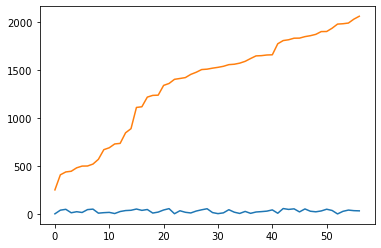

In [50]:
test_dollar_amout = merchant_daily_transaction.where(
   # != 0 is fine, but let's also take into account some more realistic filters
   (F.col('merchant_abn') == 19492220327)
   # & (F.col('order_datetime') == datetime.date(2021, 11, 28)
#    & (F.col('user_id') == 21706)
).select("dollar_amount").toPandas()

import matplotlib.pyplot as plt



sorted = test_dollar_amout.sort_values(by="dollar_amount").reset_index()["dollar_amount"]
plt.plot(sorted)

# print(test_dollar_amout.mean())
# print(test_dollar_amout.std())
print(sorted)